# VAE and AE

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

## 1. Load data, create dataset and dataloader

In [2]:
eye_data = np.load('eye/data.npy') # (1476, 50, 50, 3)
eye_data = eye_data.transpose(0, 3, 1, 2) # (1476, 3, 50, 50)
eye_data = torch.Tensor(eye_data)

eye_label = np.load('eye/label.npy') # (1476, 1)
eye_label = torch.Tensor(eye_label)


In [3]:
print(type(eye_data))

<class 'torch.Tensor'>


In [4]:
BATCH = 18  

In [5]:
class EyeDataset(Dataset):
    def __init__(self, data, label, transform=None):
        print("data shape: ", data.shape)
        print()
        self.data = data
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        if self.transform:
            data = self.transform(data)
        
        return data, label

In [6]:
eye_dataset = EyeDataset(data=eye_data, label=eye_label)

eye_dataloader = DataLoader(eye_dataset, batch_size=BATCH, shuffle=True)
for batch, label in eye_dataloader:
    print(type(batch))
    print(type(label))
    print(batch.shape)
    print(label.shape)
    # print(batch)
    break

data shape:  torch.Size([1476, 3, 50, 50])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([18, 3, 50, 50])
torch.Size([18, 1])


## 2. Model construct

In [7]:
EPOCHS = 100
LEARNING_RATE = 0.001

In [8]:
# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
            nn.Linear(64 * 7 * 7, 256),  # Add a fully connected layer
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 64 * 7 * 7),  # FC layer to map hidden vector to initial shape
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the Autoencoder
autoencoder = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

## 3. Train model

In [9]:
train_loss = []
# Training loop
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        optimizer.zero_grad()
        reconstructions = autoencoder(batch_data)
        loss = criterion(reconstructions, batch_data)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.0313
Epoch [2/100], Loss: 0.0179
Epoch [3/100], Loss: 0.0138
Epoch [4/100], Loss: 0.0099
Epoch [5/100], Loss: 0.0075
Epoch [6/100], Loss: 0.0078
Epoch [7/100], Loss: 0.0063
Epoch [8/100], Loss: 0.0069
Epoch [9/100], Loss: 0.0059
Epoch [10/100], Loss: 0.0061
Epoch [11/100], Loss: 0.0056
Epoch [12/100], Loss: 0.0053
Epoch [13/100], Loss: 0.0059
Epoch [14/100], Loss: 0.0054
Epoch [15/100], Loss: 0.0047
Epoch [16/100], Loss: 0.0054
Epoch [17/100], Loss: 0.0038
Epoch [18/100], Loss: 0.0056
Epoch [19/100], Loss: 0.0064
Epoch [20/100], Loss: 0.0042
Epoch [21/100], Loss: 0.0042
Epoch [22/100], Loss: 0.0044
Epoch [23/100], Loss: 0.0044
Epoch [24/100], Loss: 0.0045
Epoch [25/100], Loss: 0.0051
Epoch [26/100], Loss: 0.0041
Epoch [27/100], Loss: 0.0049
Epoch [28/100], Loss: 0.0050
Epoch [29/100], Loss: 0.0035
Epoch [30/100], Loss: 0.0049
Epoch [31/100], Loss: 0.0047
Epoch [32/100], Loss: 0.0058
Epoch [33/100], Loss: 0.0037
Epoch [34/100], Loss: 0.0032
Epoch [35/100], Loss: 0

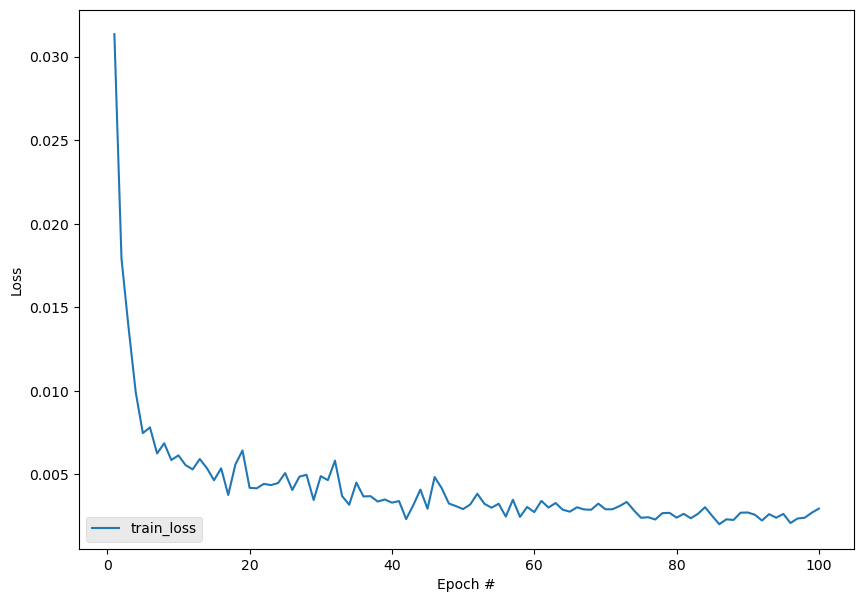

In [11]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), train_loss, label="train_loss")
# plt.plot(range(1, EPOCHS+1), test_loss, label="test_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

# fig.add_subplot(2,2,(3,4))
# plt.plot(range(1, EPOCHS+1), train_score, label="train_acc")
# plt.plot(range(1, EPOCHS+1), test_score, label="test_acc")
# plt.xlabel("Epoch #")
# plt.ylabel("Accuracy")
# plt.legend(loc="best")

# plt.savefig(f'result_picture/batch{BATCH_SIZE}_epoch{EPOCHS}_train{train_score[-1]}_test{test_score[-1]}.png')


plt.show()